# DL_comp2_全_report

## Member

- 邱煒甯, 108072244
- 劉祥暉, 109072142
- 簡佩如, 112065525
- 陳凱揚, 108032053

## 1. Data Augmentation (copy and paste)

In [1]:
import matplotlib.pyplot as plt
import cv2
import random
import os
import shutil
import numpy as np

classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]
num_classes = len(classes_name)

DATA_ROOT = '../2023-datalab-cup2-object-detection'
OLD_IMAGE_FOLDER = f'{DATA_ROOT}/VOCdevkit_train/VOC2007/JPEGImages'
NEW_IMAGE_FOLDER = f'{DATA_ROOT}/JPEGImages_Pasted_New'
OLD_TRAIN_DATA_FILE = f'{DATA_ROOT}/pascal_voc_training_data.txt'
NEW_TRAIN_DATA_FILE = f'{DATA_ROOT}/pascal_voc_training_data_pasted_new.txt'

# DATA_ROOT = '.'
# OLD_IMAGE_FOLDER = f'{DATA_ROOT}/images'
# NEW_IMAGE_FOLDER = f'{DATA_ROOT}/images_pasted'
# OLD_TRAIN_DATA_FILE = f'{DATA_ROOT}/data.txt'
# NEW_TRAIN_DATA_FILE = f'{DATA_ROOT}/data_pasted.txt'

MIN_THRESHOLD = 3000
NUM_FAILED_TO_BREAK = 2000
MIN_RATIO_TO_PASTE = 0.1
MAX_RATIO_TO_PASTE = 0.6
RANDOM_FLIP_H = True
RANDOM_FLIP_V = True
RANDOM_HSV = True
RANDOM_ROTATE = True
RANDOM_HSV = True

if os.path.exists(NEW_IMAGE_FOLDER):
    shutil.rmtree(NEW_IMAGE_FOLDER)
shutil.copytree(OLD_IMAGE_FOLDER, NEW_IMAGE_FOLDER)

'../2023-datalab-cup2-object-detection/JPEGImages_Pasted_New'

In [2]:
def display_image(filename, box=None):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, (400, 400))
    if box:
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 255), 3)
    plt.imshow(img)
    plt.show()

In [3]:
box_info_for_class = [[] for _ in range(num_classes)]
box_info_for_image = {}

with open(OLD_TRAIN_DATA_FILE, 'r') as file:
    for line in file.readlines():
        line = line.strip()
        token = line.split()
        filename = token[0]
        boxes = list(map(int, token[1:]))
        box_info_for_image[filename] = []
        for i in range(len(boxes) // 5):
            xmin, ymin, xmax, ymax, class_num = boxes[i*5:(i+1)*5]
            box_info_for_class[class_num].append((filename, xmin, ymin, xmax, ymax, class_num))
            box_info_for_image[filename].append((xmin, ymin, xmax, ymax, class_num))
            
# print(box_info_for_class[6][0])
# print(box_info_for_image)

image_hw = {}
for image_name in box_info_for_image.keys():
    file_path = f'{OLD_IMAGE_FOLDER}/{image_name}'
    img = cv2.imread(file_path)
    image_hw[image_name] = img.shape[:2]
    
# print(image_hw)

In [4]:
class Box:
    def __init__(self, box_info):
        self.image_name = box_info[0]
        self.xmin = box_info[1]
        self.ymin = box_info[2]
        self.xmax = box_info[3]
        self.ymax = box_info[4]
        self.class_num = box_info[5]
        self.box_pixel = self._get_box_pixel()
        self._random_augment()
        
    def _random_augment(self):
        if RANDOM_FLIP_H and random.random() < 0.5:
            self.box_pixel = np.flipud(self.box_pixel)
        if RANDOM_FLIP_V and random.random() < 0.5:
            self.box_pixel = np.fliplr(self.box_pixel)
        if RANDOM_ROTATE:
            rotate_count = random.randint(0, 3)
            for i in range(rotate_count):
                self.box_pixel = np.rot90(self.box_pixel)
                h, w = self.h, self.w
                self.xmax = self.xmin + h - 1
                self.ymax = self.ymin + w - 1
        if RANDOM_HSV:
            hsv_img = cv2.cvtColor(self.box_pixel, cv2.COLOR_RGB2HSV)
            random_hue = np.random.uniform(low=0, high=179)
            random_saturation = np.random.uniform(low=0.5, high=1.5)
            random_value = np.random.uniform(low=0.5, high=1.5)
            hsv_img[:, :, 0] = (hsv_img[:, :, 0] + random_hue) % 180
            hsv_img[:, :, 1] = np.clip(hsv_img[:, :, 1] * random_saturation, 0, 255)
            hsv_img[:, :, 2] = np.clip(hsv_img[:, :, 2] * random_value, 0, 255)
            self.box_pixel = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
        
    def _get_box_pixel(self):
        box_image = cv2.imread(f'{NEW_IMAGE_FOLDER}/{self.image_name}')
        box_pixel = box_image[self.ymin-1:self.ymax, self.xmin-1:self.xmax].copy()
        return box_pixel
    
    @property
    def h(self):
        return self.ymax - self.ymin + 1
    
    @property
    def w(self):
        return self.xmax - self.xmin + 1


In [5]:
def check_legal_image(t_image_name, box_info: Box):
    if t_image_name == box_info.image_name:
        return False
    
    t_h, t_w = image_hw[t_image_name]
    h_ratio = box_info.h / t_h
    w_ratio = box_info.w / t_w
    
    if not (MIN_RATIO_TO_PASTE <= h_ratio <= MAX_RATIO_TO_PASTE):
        return False
    if not (MIN_RATIO_TO_PASTE <= w_ratio <= MAX_RATIO_TO_PASTE):
        return False
    
    return True

def check_legal_region(t_image_name, t_xmin, t_ymin, t_xmax, t_ymax):
    t_h, t_w = image_hw[t_image_name]
    if t_xmin <= 0 or t_ymin <= 0 or t_xmax > t_w or t_ymax > t_h:
        return False

    for xmin, ymin, xmax, ymax, class_num in box_info_for_image[t_image_name]:
        if xmin < t_xmax and xmax > t_xmin and ymin < t_ymax and ymax > t_ymin:
            return False

    return True

def find_random_region(box_info: Box):
    for i in range(NUM_FAILED_TO_BREAK):
        target_image_name = random.choice(list(image_hw.keys()))
        if not check_legal_image(target_image_name, box_info):
            continue
        
        target_h, target_w = image_hw[target_image_name]
        target_x = random.choice(range(1, max(1, target_w - box_info.w + 2)))
        target_y = random.choice(range(1, max(1, target_h - box_info.h + 2)))
        if not check_legal_region(target_image_name, target_x, target_y, target_x+box_info.w-1, target_y+box_info.h-1):
            continue

        return target_image_name, target_x, target_y
    
    return None

def copy_paste(box_info: Box, target_image):
    target_image_name, target_x, target_y = target_image
    
    target_image = cv2.imread(f'{NEW_IMAGE_FOLDER}/{target_image_name}')
    target_image[target_y-1:target_y+box_info.h-1, target_x-1:target_x+box_info.w-1] = box_info.box_pixel
    
    box_info_for_image[target_image_name].append((target_x, target_y, target_x+box_info.w-1, target_y+box_info.h-1, box_info.class_num))
    cv2.imwrite(f'{NEW_IMAGE_FOLDER}/{target_image_name}', target_image)
#     display_image(f'{NEW_IMAGE_FOLDER}/{target_image_name}', (target_x, target_y, target_x+box_info.w-1, target_y+box_info.h-1))


In [6]:
for idx, box_list in enumerate(box_info_for_class):
    num_try = MIN_THRESHOLD - len(box_list)
    for i in range(num_try):
        box_info = random.choice(box_list)
        box_info = Box(box_info)
        target_image = find_random_region(box_info)
        if target_image is not None:
            copy_paste(box_info, target_image)


In [7]:
classes_num = [0 for _ in range(num_classes)]

for image_name, box_info_list in box_info_for_image.items():
    for xmin, ymin, xmax, ymax, class_num in box_info_list:
        classes_num[class_num] += 1
        
for i, v in enumerate(classes_num):
    print(f'{classes_name[i]:>13s} {v:>5d}')

    aeroplane  1500
      bicycle  2320
         bird  2086
         boat  1920
       bottle  1842
          bus  1641
          car  2274
          cat  1052
        chair  2550
          cow  1739
  diningtable   994
          dog  1144
        horse  1150
    motorbike  1260
       person  5392
  pottedplant  1895
        sheep  1227
         sofa   816
        train   842
    tvmonitor  1612


In [8]:
with open(NEW_TRAIN_DATA_FILE, 'w') as file:
    for image_name, box_info_list in box_info_for_image.items():
        line = image_name + ' ' + ' '.join(' '.join(list(map(str, box_info))) for box_info in box_info_list) + '\n'
        file.write(line)

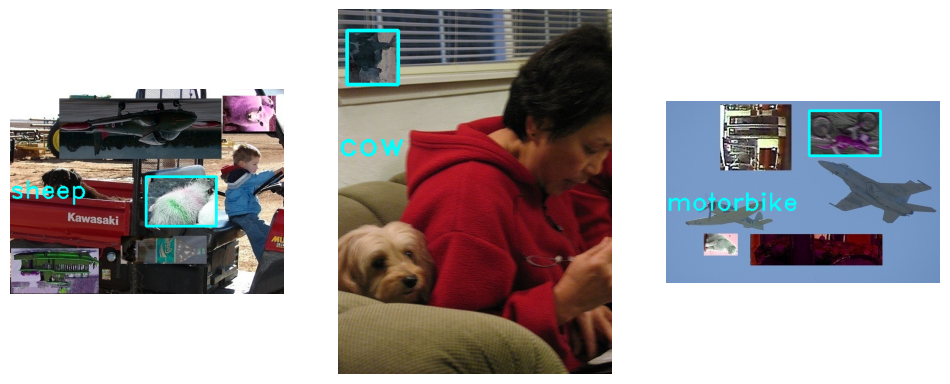

In [9]:
import cv2

def display_images_with_boxes(folder_path, image_names, labels, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    for i, ax in enumerate(axes.flat):
        np_img = cv2.imread(f'{folder_path}/{image_names[i]}')
        np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)
        resized_img = np_img

        xmin, ymin, xmax, ymax, class_num = labels[i][-5:]
        class_name = classes_name[int(class_num)]
        cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
        cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)
        ax.imshow(resized_img)
        ax.axis('off')
    plt.show()
    
def random_select_images_with_boxes(data_file, num_images):
    input_file = open(data_file, 'r')
    image_infos = []
    for line in input_file:
        line = line.strip()
        ss = line.split(' ')
        image_infos.append((ss[0], [float(num) for num in ss[1:]]))
    selected_infos = random.sample(image_infos, min(num_images, len(image_infos)))
    image_names = [image_name for image_name, _ in selected_infos]
    labels = [label for _, label in selected_infos]
    return image_names, labels
    
num_images_to_select = 16
selected_image_names, selected_labels = random_select_images_with_boxes(NEW_TRAIN_DATA_FILE, num_images_to_select)

display_images_with_boxes(NEW_IMAGE_FOLDER, selected_image_names, selected_labels, rows=1, cols=3)

## 2. Ensemble Learning (weighted_boxes_fusion)

### 2.1 Setup

In [1]:
# !sudo apt-get -y update 
# !sudo apt-get -y install libgl1
# !sudo -s -H python -m pip install --upgrade pip
# !sudo -s -H pip install opencv-python
# !sudo -s -H pip install cryptography
# !sudo -s -H pip install matplotlib
# !sudo -s -H pip install ensemble-boxes
import os
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '0'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit'
!nvidia-smi

Thu Nov 23 23:03:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 12.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:DC:00.0 Off |                    0 |
| N/A   32C    P0   253W / 300W |  16877MiB / 32510MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]
DATA_ROOT = '/home/u6180060/DL/C2/2023-datalab-cup2-object-detection'

In [23]:
import tensorflow as tf
import numpy as np

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [21]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 32
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
# DATA_PATH = f'{DATA_ROOT}/pascal_voc_training_data.txt'
# IMAGE_DIR = f'{DATA_ROOT}/VOCdevkit_train/VOC2007/JPEGImages/'
# PASTED_DATA_PATH = f'{DATA_ROOT}/pascal_voc_training_data_pasted_new.txt'
# PASTED_IMAGE_DIR = f'{DATA_ROOT}/JPEGImages_Pasted_New/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 300

# ensemble params
IOU_THR = 0.01
SKIP_BOX_THR = 0.001
CONF_TYPE = 'max' # avg, max, box_and_model_avg, absent_model_aware_avg

### 2.2 Model

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

def resnet_layer():
    resnet = tf.keras.applications.resnet.ResNet152(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    resnet.trainable = False
    
    return resnet

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resnet_layer()(img_inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO1 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO1")

YOLO1.summary()

ckpt1 = tf.train.Checkpoint(net=YOLO1)
manager1 = tf.train.CheckpointManager(ckpt1, '/work/u6180060/DL/ckpts/YOLO', max_to_keep=3)
ckpt1.restore(manager1.latest_checkpoint)

Model: "YOLO1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 14, 14, 2048)      58370944  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

def resnet_layer():
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    resnet.trainable = False
    
    return resnet

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resnet_layer()(img_inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO2 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO2")

YOLO2.summary()

ckpt2 = tf.train.Checkpoint(net=YOLO2)
manager2 = tf.train.CheckpointManager(ckpt2, '/work/u6180060/DL/ckpts/YOLO2', max_to_keep=3)
ckpt2.restore(manager2.latest_checkpoint)

Model: "YOLO2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 14, 14, 2048)      23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 4096)              8392704   
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                             

In [7]:
def EfficientNet_layer():
    EfficientNet = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    EfficientNet.trainable = False
    
    return EfficientNet

def ResNet_layer():
    ResNet=tf.keras.applications.ResNet152V2(include_top=False, weights='imagenet')
    ResNet.trainable = False
    
    return ResNet

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = EfficientNet_layer()(img_inputs)
x = layers.GlobalAvgPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO3 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO3")

YOLO3.summary()

ckpt3 = tf.train.Checkpoint(net=YOLO3)
manager3 = tf.train.CheckpointManager(ckpt3, '/home/u6180060/DL/chiu/ckpts/YOLO/EN', max_to_keep=3)
ckpt3.restore(manager3.latest_checkpoint)

Model: "YOLO3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 efficientnetb7 (Functional  (None, 14, 14, 2560)      64097687  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_2 (Flatten)         (None, 2560)              0         
                                                                 
 dense_4 (Dense)             (None, 2048)              5244928   
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0     

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

def conv_leaky_relu(inputs, filters, size, stride,dropout_rate=None):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.1)(x)

    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)
    
    return x

def ResNet_layer():
    ResNet = tf.keras.applications.ResNet152V2(include_top=False, weights='imagenet')
    ResNet.trainable = False
    
    return ResNet

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = ResNet_layer()(img_inputs)
x = conv_leaky_relu(x, 64, 3, 1)
x = conv_leaky_relu(x, 64, 3, 1)
x = conv_leaky_relu(x, 64, 3, 1)
x = conv_leaky_relu(x, 64, 3, 1)
x = conv_leaky_relu(x, 64, 3, 1)
x = conv_leaky_relu(x, 64, 3, 1)
x = layers.Flatten()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO4 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO4")

YOLO4.summary()

ckpt4 = tf.train.Checkpoint(net=YOLO4)
manager4 = tf.train.CheckpointManager(ckpt4, '/home/u6180060/DL/chiu/ckpts/YOLO/Resnet152V2_conv_6', max_to_keep=3)
ckpt4.restore(manager4.latest_checkpoint)

Model: "YOLO4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, None, None, 2048   58331648  
                             )                                   
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        1179712   
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        36928 

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

def conv_leaky_relu(inputs, filters, size, stride):
    x = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
    x = layers.LeakyReLU(0.1)(x)

    return x

def resnet_layer():
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    resnet.trainable = True
    
    return resnet

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resnet_layer()(img_inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO5 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO5")

YOLO5.summary()

ckpt5 = tf.train.Checkpoint(net=YOLO5)
manager5 = tf.train.CheckpointManager(ckpt5, '/work/u6180060/DL/ckpts/YOLO4', max_to_keep=3)
ckpt5.restore(manager5.latest_checkpoint)

Model: "YOLO5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 14, 14, 2048)      23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 2048)              4196352   
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                             

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

mobilenet_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
mobilenet_model.trainable = False

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
mobilenet_output = mobilenet_model(img_inputs)
x = layers.Conv2D(256, 3, padding="same", activation='relu')(mobilenet_output)
x = layers.Conv2D(64, 4, padding="same", activation='relu')(x)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(x, 128, 8, 2)
x = conv_leaky_relu(x, 512, 4, 1)
x = conv_leaky_relu(x, 1024, 2, 1)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO6 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO6")

YOLO6.summary()

ckpt6 = tf.train.Checkpoint(net=YOLO6)
manager6 = tf.train.CheckpointManager(ckpt6, '/home/u6180060/DL/chiu/ckpts/YOLO/Mobile_conv_pei', max_to_keep=3)
ckpt6.restore(manager6.latest_checkpoint)

Model: "YOLO6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 448, 448, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 14, 14, 1280)      2257984   
 tional)                                                         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 256)       2949376   
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        262208    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         524416

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

mobilenet_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
mobilenet_model.trainable = False

img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
mobilenet_output = mobilenet_model(img_inputs)
x = layers.GlobalAveragePooling2D()(mobilenet_output)
x = layers.Flatten()(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1470, activation='linear')(x)


YOLO7 = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO7")

YOLO7.summary()

ckpt7 = tf.train.Checkpoint(net=YOLO7)
manager7 = tf.train.CheckpointManager(ckpt7, '/home/u6180060/DL/chiu/ckpts/YOLO/Mobile_globalpool', max_to_keep=3)
ckpt7.restore(manager7.latest_checkpoint)

Model: "YOLO7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 448, 448, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 14, 14, 1280)      2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 flatten_6 (Flatten)         (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 2048)              2623488   
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0     

### 2.3 Predict

In [12]:
def process_outputs(outputs):
    """
    Process YOLO outputs into bounding boxes
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return xmin, ymin, xmax, ymax, class_num, max_conf

In [13]:
from ensemble_boxes import weighted_boxes_fusion

def weighted_process_outputs(outputs, weights):
    scores_list = None
    boxes_list = None
    labels_list = None
    for n in range(len(outputs)):
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = np.reshape(outputs[n][:, 0:class_end], (-1, 7, 7, 20))
        confs = np.reshape(outputs[n][:, class_end:conf_end], (-1, 7, 7, 2))#score
        boxes = np.reshape(outputs[n][:, conf_end:], (-1, 7, 7, 2*4))
        predicts = np.concatenate([class_probs, confs, boxes], 3)
        
        now_boxes = np.reshape(outputs[n][:, conf_end:], (7,7,2,4))
        tmp = []
        for i in range(len(now_boxes)):
            tmp1 = []
            for j in range(len(now_boxes[i])):
                tmp2 = []
                for k in range(len(now_boxes[i][j])):
                    xcenter = now_boxes[i][j][k][0]
                    ycenter = now_boxes[i][j][k][1]
                    w = now_boxes[i][j][k][2]
                    h = now_boxes[i][j][k][3]    
                    xcenter = (j + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
                    ycenter = (i + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

                    w = w * IMAGE_SIZE
                    h = h * IMAGE_SIZE

                    xmin = xcenter - w/2.0
                    ymin = ycenter - h/2.0

                    xmax = xmin + w
                    ymax = ymin + h
                    tmp2.append([xmin,ymin,xmax,ymax])
                tmp1.append(tmp2)
            tmp.append(tmp1)
        now_boxes = np.array(tmp)
        now_boxes = np.expand_dims(now_boxes,0)
        now_boxes = np.reshape(now_boxes,(-1,7*7*2,4))        
        
        p_classes = predicts[0, :, :, 0:20]
        C = predicts[0, :, :, 20:22]
        # coordinate = predicts[0, :, :, 22:]

        p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
        C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

        P = C * p_classes
        #P's shape [7, 7, 2, 20]

        now_labels = np.argmax(P, axis=3)
        now_score = np.max(P,3)
        # print(now_score.shape)
        now_score = np.reshape(now_score,(-1,7*7*2))
        # The labels array will have shape [7, 7, 2], so we need to expand its dimensions
        # labels = np.expand_dims(labels, axis=3)
        now_labels = np.reshape(now_labels,(-1,7*7*2))
        
        if n == 0:
            scores_list = now_score
            boxes_list = now_boxes
            labels_list = now_labels
        else:
            scores_list = np.concatenate([scores_list,now_score],0)
            boxes_list = np.concatenate([boxes_list,now_boxes],0)
            labels_list = np.concatenate([labels_list,now_labels],0)
        # print(boxes_list.shape)
        # print(scores_list.shape)
        # print(labels_list.shape)
        
    boxes_list /= IMAGE_SIZE
    boxes, scores, labels = weighted_boxes_fusion(
        boxes_list.tolist(),
        scores_list.tolist(),
        labels_list.tolist(),
        weights=weights,
        iou_thr=IOU_THR,
        skip_box_thr=SKIP_BOX_THR,
        conf_type=CONF_TYPE,
    )
    id = np.argmax(scores)
    xmin, ymin, xmax, ymax = tuple(boxes[id])
    xmin *= IMAGE_SIZE
    ymin *= IMAGE_SIZE
    xmax *= IMAGE_SIZE
    ymax *= IMAGE_SIZE
    max_conf = scores[id]
    class_num = labels[id]

    return xmin, ymin, xmax, ymax, class_num, max_conf

In [14]:
test_img_files = open(f'{DATA_ROOT}/pascal_voc_testing_data.txt')
test_img_dir = f'{DATA_ROOT}/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data1(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
#     image = (image/255) * 2 - 1
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)

    return image_name, image, h, w


def load_img_data2(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
#     image = (image/255) * 2 - 1
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)

    return image_name, image, h, w


def load_img_data3(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
#     image = (image/255) * 2 - 1
    image = tf.cast(image, tf.float32)
#     image = tf.keras.applications.resnet.preprocess_input(image)

    return image_name, image, h, w


def load_img_data4(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
#     image = (image/255) * 2 - 1
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet_v2.preprocess_input(image)

    return image_name, image, h, w


def load_img_data5(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
#     image = (image/255) * 2 - 1
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)

    return image_name, image, h, w


def load_img_data6(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
#     image = (image/255) * 2 - 1
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    return image_name, image, h, w


def load_img_data7(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
#     image = (image/255) * 2 - 1
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    return image_name, image, h, w


test_dataset1 = test_dataset.map(load_img_data1, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset1 = test_dataset1.batch(BATCH_SIZE)

test_dataset2 = test_dataset.map(load_img_data2, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset2 = test_dataset2.batch(BATCH_SIZE)

test_dataset3 = test_dataset.map(load_img_data3, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset3 = test_dataset3.batch(BATCH_SIZE)

test_dataset4 = test_dataset.map(load_img_data4, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset4 = test_dataset4.batch(BATCH_SIZE)

test_dataset5 = test_dataset.map(load_img_data5, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset5 = test_dataset5.batch(BATCH_SIZE)

test_dataset6 = test_dataset.map(load_img_data6, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset6 = test_dataset6.batch(BATCH_SIZE)

test_dataset7 = test_dataset.map(load_img_data7, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset7 = test_dataset7.batch(BATCH_SIZE)

In [15]:
@tf.function
def prediction_step(model, img):
    return model(img, training=False)

In [16]:
output_file = open('./test_prediction_ensemble.txt', 'w')
output_data = ''

models = [YOLO1, YOLO2, YOLO3, YOLO4, YOLO5, YOLO6, YOLO7]
test_dataset = (test_dataset1, test_dataset2, test_dataset3, test_dataset4, test_dataset5, test_dataset6, test_dataset7)
weights = [1, 1, 1, 1, 1, 1, 1]
output_datas = ['' for _ in range(7)]

for imgs in zip(*test_dataset):
    img_name, test_img, img_h, img_w = imgs[0]
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        outputs = []
        for idx, (_img_name, _test_img, _img_h, _img_w) in enumerate(imgs):
            predict = prediction_step(models[idx], _test_img[i:i+1])
            outputs.append(predict)
            
            xmin, ymin, xmax, ymax, class_num, conf = process_outputs(predict)
            xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)
            output_datas[idx] += img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf)
        
        xmin, ymin, xmax, ymax, class_num, conf = weighted_process_outputs(outputs, weights)
        xmin, ymin, xmax, ymax = xmin*(img_w[i:i+1]/IMAGE_SIZE), ymin*(img_h[i:i+1]/IMAGE_SIZE), xmax*(img_w[i:i+1]/IMAGE_SIZE), ymax*(img_h[i:i+1]/IMAGE_SIZE)

        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_data += img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf)

for i, data in enumerate(output_datas):
    with open(f'./test_prediction_{i}.txt', 'w') as file:
        file.write(data)

output_file.write(output_data)
output_file.close()

2023-11-23 23:04:31.388068: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f549000a1a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-11-23 23:04:31.388098: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-11-23 23:04:31.473716: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-11-23 23:04:37.445423: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56437afc01f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 23:04:37.445466: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2023-11-23 23:04:37.528856: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODU

/usr/local/lib/python3.10/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:54: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')
/usr/local/lib/python3.10/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:36: UserWarning: X2 < X1 value in box. Swap them.
  warnings.warn('X2 < X1 value in box. Swap them.')
/usr/local/lib/python3.10/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:42: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')
/usr/local/lib/python3.10/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:63: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/usr/local/lib/python3.10/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:51: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Che

In [17]:
import sys
sys.path.insert(0, './evaluate')

In [18]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction_ensemble.txt', './output_file_ensemble.csv')

for i in range(7):
    evaluate.evaluate(f'./test_prediction_{i}.txt', f'./output_file_{i}.csv')

End Evalutation
End Evalutation
End Evalutation
End Evalutation
End Evalutation
End Evalutation
End Evalutation
End Evalutation


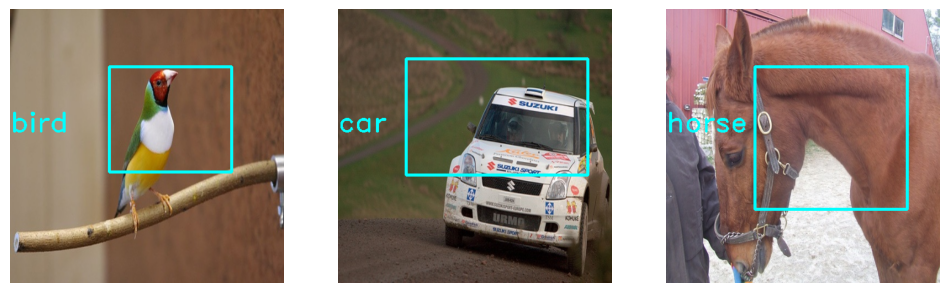

In [31]:
import matplotlib.pyplot as plt
import cv2
import random

def display_images_with_boxes(folder_path, image_names, labels, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 15))
    for i, ax in enumerate(axes.flat):
        np_img = cv2.imread(f'{folder_path}/{image_names[i]}')
        np_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
        np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)
        resized_img = np_img

        xmin, ymin, xmax, ymax, class_num = labels[i][-5:]
        class_name = classes_name[int(class_num)]
        cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
        cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)
        ax.imshow(resized_img)
        ax.axis('off')
    plt.show()
    
def random_select_images_with_boxes(data_file, num_images):
    input_file = open(data_file, 'r')
    image_infos = []
    for line in input_file:
        line = line.strip()
        ss = line.split(' ')
        image_infos.append((ss[0], [float(num) for num in ss[1:-1]]))
    selected_infos = random.sample(image_infos, min(num_images, len(image_infos)))
    image_names = [image_name for image_name, _ in selected_infos]
    labels = [label for _, label in selected_infos]
    return image_names, labels
    
num_images_to_select = 16
selected_image_names, selected_labels = random_select_images_with_boxes('./test_prediction_ensemble.txt', num_images_to_select)

display_images_with_boxes(f'{DATA_ROOT}/VOCdevkit_test/VOC2007/JPEGImages/', selected_image_names, selected_labels, rows=1, cols=3)